In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import gym
from collections import deque
import random
import itertools
from torch import nn
from torch.nn import functional
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import pickle

def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')


def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None

cpu


In [13]:
class RBFDiscritizer:
    def __init__(self, num_rbf_per_state, state_bounds, num_states):
        self.num_rbf_per_state = num_rbf_per_state
        self.state_bounds = state_bounds
        self.num_states = num_states
        self.num_rbf = num_rbf_per_state * np.ones(self.num_states).astype(int)
        self.num_ind = np.prod(self.num_rbf)
        self.width = 1. / (self.num_rbf - 1.)
        self.rbf_sigma = self.width[0] / 2.
        self.rbf_den = 2 * self.rbf_sigma ** 2
        self.centres = self.build_centers()

    def build_centers(self):
        # Generate a meshgrid for the centers based on the number of RBFs per dimension
        ranges = [np.linspace(0, 1, num) for num in self.num_rbf]
        mesh = np.meshgrid(*ranges, indexing='ij')
        # Flatten the meshgrid and stack it to get the center coordinates
        center_coords = np.stack([axis.flatten() for axis in mesh], axis=-1)
        return center_coords

    def normalize_state(self, state):
        normalized = np.zeros(len(state))
        for i, (lower, upper) in enumerate(self.state_bounds):
            normalized[i] = (state[i] - lower) / (upper - lower)
        return normalized

    def encode(self, state):
        normalized_state = self.normalize_state(state)
        _phi = np.zeros(self.num_ind)
        for _k in range(self.num_ind):
            _phi[_k] = np.exp(-np.linalg.norm(normalized_state - self.centres[_k, :]) ** 2 / self.rbf_den)
        return _phi

In [14]:
class Model(nn.Module):
    def __init__(self, input_features, output_values):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=input_features, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=output_values)

    def forward(self, x):
        x = functional.selu(self.fc1(x))
        x = functional.selu(self.fc2(x))
        x = self.fc3(x)
        return x

class DDQN:
    def __init__(self, env, num_tiles, discretizer, steps_per_dim, use_cuda=True, learning_rate=1e-5, gamma=0.99, memory_len=10000, start_epsilon=1):
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.env = env
        self.discrete_actions = discretize_action(env)
        self.discretizer = discretizer
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.n_features = len(env.observation_space.high)
        self.steps_per_dimension = steps_per_dim
        self.action_list = self.discrete_actions.discretize_action_space(self.steps_per_dimension)

        self.epsilon = start_epsilon
        self.min_epsilon = 0.01
        self.epsilon_decay = 0.09 / 5e3
        self.memory_len = memory_len
        self.memory = deque(maxlen=self.memory_len)
        self.criterion = nn.MSELoss()

        input_features = num_tiles
        output_values = len(self.action_list)
        self.policy_net = Model(input_features, output_values).to(self.device)
        self.target_net = Model(input_features, output_values).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def get_states_tensor(self, sample, states_idx):
        sample_len = len(sample)
        states_tensor = torch.empty((sample_len, self.n_features), dtype=torch.float32, requires_grad=False)

        features_range = range(self.n_features)
        for i in range(sample_len):
            for j in features_range:
                states_tensor[i, j] = sample[i][states_idx][j].item()

        return states_tensor

    def normalize_state(self, state):
        if type(state) == tuple:
            state = state[0]
        state[0] /= 1.8
        state[1] /= 0.14


    def state_reward(self, state, env_reward):
        return env_reward - (abs(state[0]) + abs(state[1])) / 2.5

    def get_action(self, state, e=0.001):
        if random.random() < e:
            return np.random.randint(len(self.action_list))
        else:
            encoded_state = self.discretizer.encode(state)
            encoded_state = torch.tensor(encoded_state, dtype=torch.float32, device=self.device)
            return self.policy_net(encoded_state).argmax().item()

    def fit(self, model, inputs, labels):
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        train_ds = TensorDataset(inputs, labels)
        train_dl = DataLoader(train_ds, batch_size=5)

        optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)
        model.train()
        total_loss = 0.0

        for x, y in train_dl:
            out = model(x)
            loss = self.criterion(out, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        return total_loss / len(train_dl)

    def optimize_model(self, train_batch_size=100):
        if len(self.memory) < train_batch_size:
            return
        train_sample = random.sample(self.memory, train_batch_size)

        state = torch.tensor([s[0] for s in train_sample], dtype=torch.float32, device=device)
        next_state = torch.tensor([s[3] for s in train_sample], dtype=torch.float32, device=device)

        q_estimates = self.policy_net(state).detach()
        next_state_q_estimates = self.target_net(next_state).detach()
        next_actions = self.policy_net(next_state).argmax(dim=1)

        for i in range(len(train_sample)):
            next_action = next_actions[i].item()
            q_estimates[i][train_sample[i][1]] = (train_sample[i][2] +
                                                  self.gamma * next_state_q_estimates[i][next_action].item())

        self.fit(self.policy_net, state, q_estimates)

    def train_one_episode(self):
        current_state = self.env.reset()
        #self.normalize_state(current_state)
        done = False
        score = 0
        reward = 0
        step = 0
        while not done and step < 999:
            if type(current_state) == tuple:
                current_state = current_state[0]
            action = self.get_action(current_state, self.epsilon)
            next_state, env_reward, done,  _ = self.env.step(self.action_list[action])
            #self.normalize_state(next_state)
            encoded_current_state = self.discretizer.encode(current_state)
            encoded_next_state = self.discretizer.encode(next_state)
            self.memory.append((encoded_current_state, action, env_reward, encoded_next_state))
            current_state = next_state
            score += env_reward
            reward += self.state_reward(next_state, env_reward)

            self.optimize_model(100)
            step += 1

            self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

        return score, reward, step

    def test(self):
        state = self.env.reset()
        #self.normalize_state(state)
        done = False
        score = 0
        reward = 0
        step = 0
        while not done and step < 999:
            if type(state) == tuple:
                state = state[0]
            action = self.get_action(state, 0)  # Using 0 to bypass random action selection
            #print(self.action_list[action])
            state, env_reward, done,  _ = self.env.step(self.action_list[action])
            if env_reward == 100:
                print(step)
            #self.normalize_state(state)
            score += env_reward
            reward += self.state_reward(state, env_reward)
            step += 1

        return score, reward

class discretize_action:
    def __init__(self, env) -> None:
        self.env = env
        self.action_space = self.env.action_space

    def discretize_action_space(self, steps_per_dimension):
        """
        Discretizes the action space.

        Parameters:
        - low: The lower bound of the action space.
        - high: The higher bound of the action space.
        - steps_per_dimension: Number of discrete steps per dimension.

        Returns:
        - A list of discretized actions.
        """
        low = self.action_space.low
        high = self.action_space.high

        # Generate a range of values for each dimension
        ranges = [np.linspace(low[i], high[i], steps_per_dimension) for i in range(len(low))]

        # Create a meshgrid of all possible combinations
        mesh = np.meshgrid(*ranges)

        # Reshape the meshgrid to create a list of actions
        self.actions = np.vstack([m.flatten() for m in mesh]).T

        return self.actions
    

In [15]:
def main(used_alpha, used_epsilon, env, num_tiles, discretizer, steps_per_dim, target_update_delay, test_delay, memory_len=10000, num_runs=1, num_episode=1000, save_file=""):


    # Initialize storage for reward data
    rewards_data = {epsilon: {alpha: [] for alpha in used_alpha} for epsilon in used_epsilon}

    for epsilon in used_epsilon:
        for alpha in used_alpha:
            print(f"Training with epsilon: {epsilon}, alpha: {alpha}")
            run_rewards = []  # Collect rewards for each run for the current config

            for run in range(num_runs):

                # avoid decay
                current_epsilon = epsilon

                print(f"Run {run + 1}/{num_runs}")

                # renew the wrapper class
                ddqn = DDQN(
                    env=env,
                    num_tiles = num_tiles,
                    discretizer=discretizer,
                    steps_per_dim= steps_per_dim,
                    use_cuda=True,
                    learning_rate=alpha,
                    gamma=0.7,
                    memory_len=memory_len,
                    start_epsilon=current_epsilon
                )

                best_test_reward = 0

                episode_rewards = []  # Collect rewards for each episode in the current run
                for i in range(num_episode):
                    score, reward, step = ddqn.train_one_episode()

                    print(f'Episode {i + 1}: score: {score} - reward: {reward}, test step: {step}')

                    if i % target_update_delay == 0:
                        ddqn.target_net.load_state_dict(ddqn.policy_net.state_dict())
                        ddqn.target_net.eval()

                    if (i + 1) % test_delay == 0:
                        test_score, test_reward = ddqn.test()
                        print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
                        if test_reward > best_test_reward:
                            print('New best test reward. Saving model')
                            best_test_reward = test_reward
                            # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                    # Add the rewards
                    episode_rewards.append(score)

                if num_episode % test_delay != 0:
                    test_score, test_reward = ddqn.test()
                    print(f'Test Episode {num_episode}: test score: {test_score} - test reward: {test_reward}')
                    if test_reward > best_test_reward:
                        print('New best test reward. Saving model')
                        best_test_reward = test_reward
                        # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                # save the run rewards
                run_rewards.append(episode_rewards)

                print(f'best test reward: {best_test_reward}')

            # Store the rewards for the current epsilon and alpha configuration
            rewards_data[epsilon][alpha] = run_rewards

    if not(save_file == ""):
        save_rewards_data(rewards_data, save_file)

    return rewards_data

In [17]:
env = gym.make('MountainCarContinuous-v0')

num_states = 2
num_rbf_per_state=4
state_bounds = [(-1.2, 0.6), (-0.07, 0.07)]  # Bounds 

discretizer = RBFDiscritizer(num_rbf_per_state=num_rbf_per_state, state_bounds=state_bounds, num_states=num_states)

num_tiles=discretizer.num_ind

In [19]:
rewards_data = main(
    used_alpha=[1e-9],
    used_epsilon=[0.1],  # start epsilon
    env=env,
    num_tiles= num_tiles,
    discretizer=discretizer,
    steps_per_dim= 5,
    target_update_delay=2,
    test_delay=10,
    memory_len=10000,
    num_runs=2,
    num_episode=500,
    save_file="t3tes.pkl"
)

Training with epsilon: 0.1, alpha: 1e-09
Run 1/2
Episode 1: score: 79.02499999999999 - reward: 46.64440364884216, test step: 244
Episode 2: score: 70.89999999999989 - reward: 23.611082797497488, test step: 341
Episode 3: score: 77.17499999999994 - reward: 41.41710308790208, test step: 269
Episode 4: score: 67.84999999999984 - reward: 16.69337832778689, test step: 380
Episode 5: score: 64.34999999999982 - reward: 12.595776685327252, test step: 386
Episode 6: score: 78.67499999999998 - reward: 46.48825359772893, test step: 245
Episode 7: score: 72.1749999999999 - reward: 30.285348215885392, test step: 313
Episode 8: score: 71.17499999999988 - reward: 24.695041809231057, test step: 344
Episode 9: score: 71.02499999999988 - reward: 25.700645591318604, test step: 341
Episode 10: score: 76.12499999999996 - reward: 40.31585995703936, test step: 270
Test Episode 10: test score: 78.69999999999996 - test reward: 47.898658723197904
New best test reward. Saving model
Episode 11: score: 79.07499999

In [20]:
import matplotlib.pyplot as plt

def plot_rewards(rewards_data, algorithm_name="Q learning"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

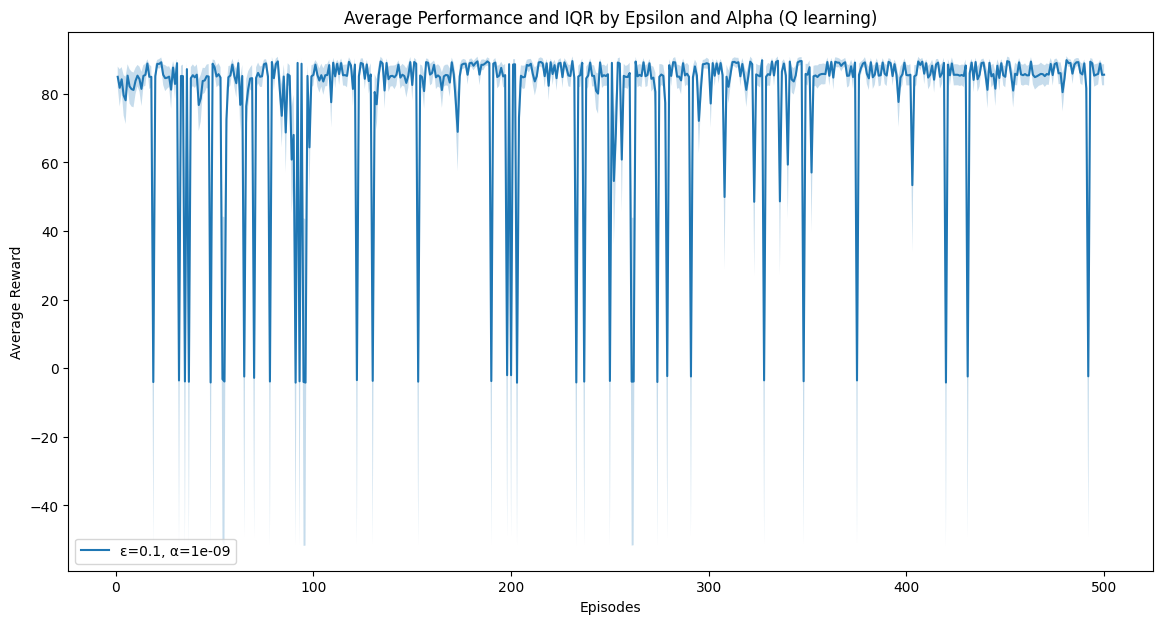

In [21]:
plot_rewards(rewards_data)

In [51]:
rewards_data = main(
    used_alpha=[1e-9],
    used_epsilon=[0.5],  # start epsilon
    env=env,
    num_tiles= num_tiles,
    discretizer=discretizer,
    steps_per_dim= 5,
    target_update_delay=2,
    test_delay=10,
    memory_len=10000,
    num_runs=1,
    num_episode=500,
    save_file="t3te_fs.pkl"
)

Training with epsilon: 0.5, alpha: 1e-09
Run 1/1
Episode 1: score: 77.52499999999998 - reward: -40.042311932146376, test step: 566
Episode 2: score: 75.54999999999998 - reward: -65.14346048906452, test step: 668
Episode 3: score: -32.84999999999998 - reward: -242.68822023719562, test step: 999
Episode 4: score: 86.525 - reward: 24.542535462975522, test step: 301
Episode 5: score: 81.97500000000001 - reward: -12.473997912183421, test step: 458
Episode 6: score: -31.774999999999974 - reward: -241.3568205319345, test step: 999
Episode 7: score: -29.650000000000002 - reward: -243.81289294622815, test step: 999
Episode 8: score: 87.35000000000001 - reward: 5.2492231629787796, test step: 389
Episode 9: score: 79.95 - reward: -71.26899299621559, test step: 716
Episode 10: score: 83.17500000000001 - reward: 12.856429551914346, test step: 351
Test Episode 10: test score: -10.999999999999995 - test reward: -222.83733251020314
Episode 11: score: 89.2 - reward: 24.242991818860105, test step: 316
E

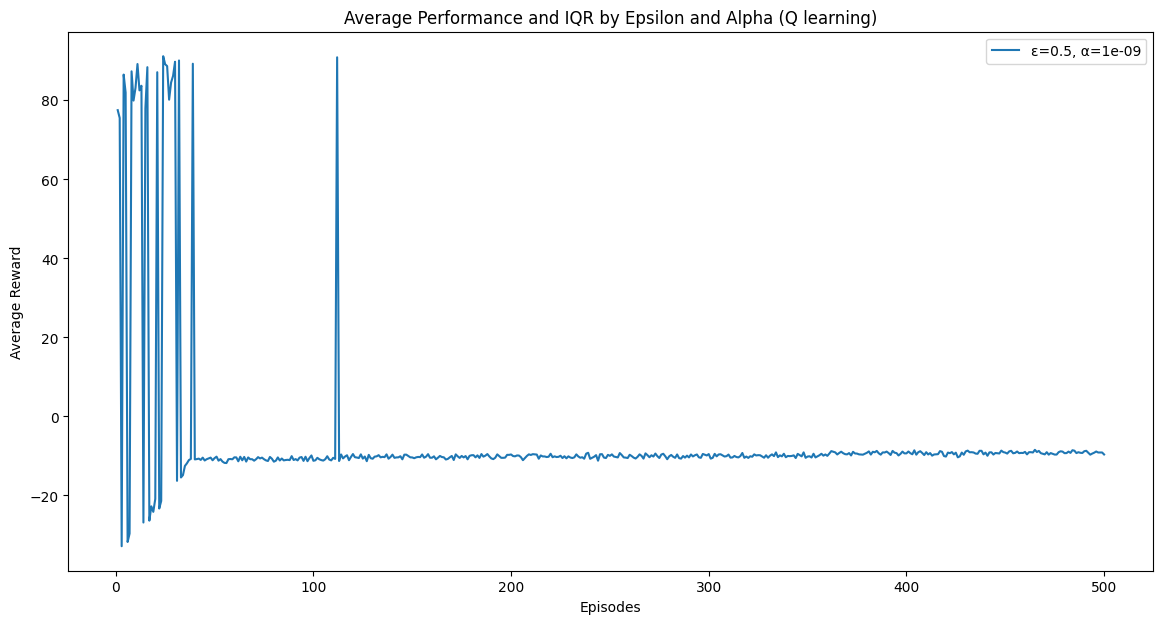

In [52]:
plot_rewards(rewards_data)


In [53]:
data = load_rewards_data("t3tes.pkl")

Rewards data loaded from t3tes.pkl


In [54]:
def prune_rewards_data(rewards_data, epsilon, alpha, index):
    # Check if epsilon and alpha values are valid
    if epsilon not in rewards_data or alpha not in rewards_data[epsilon]:
        print("Invalid epsilon or alpha value.")
        return

    # Check if index is within the bounds
    if index < 0 or index >= len(rewards_data[epsilon][alpha]):
        print("Index out of range.")
        return

    # Keep only the value at the specified index
    rewards_data[epsilon][alpha] = [rewards_data[epsilon][alpha][index]]

In [56]:
prune_rewards_data(data, 0.1, 1e-9, 0)

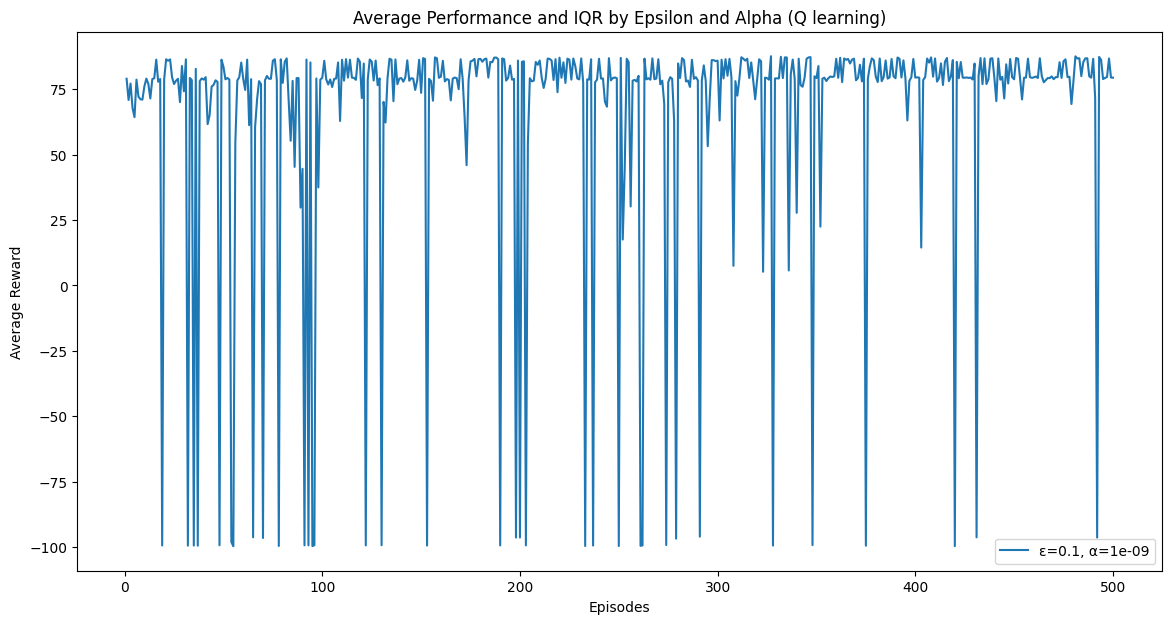

In [57]:
plot_rewards(data)

In [58]:
save_rewards_data(data, "MCC_DDQN_RBF_0.1_1run")

Rewards data saved to MCC_DDQN_RBF_0.1_1run


In [59]:
data = load_rewards_data("t3te_fs.pkl")

Rewards data loaded from t3te_fs.pkl


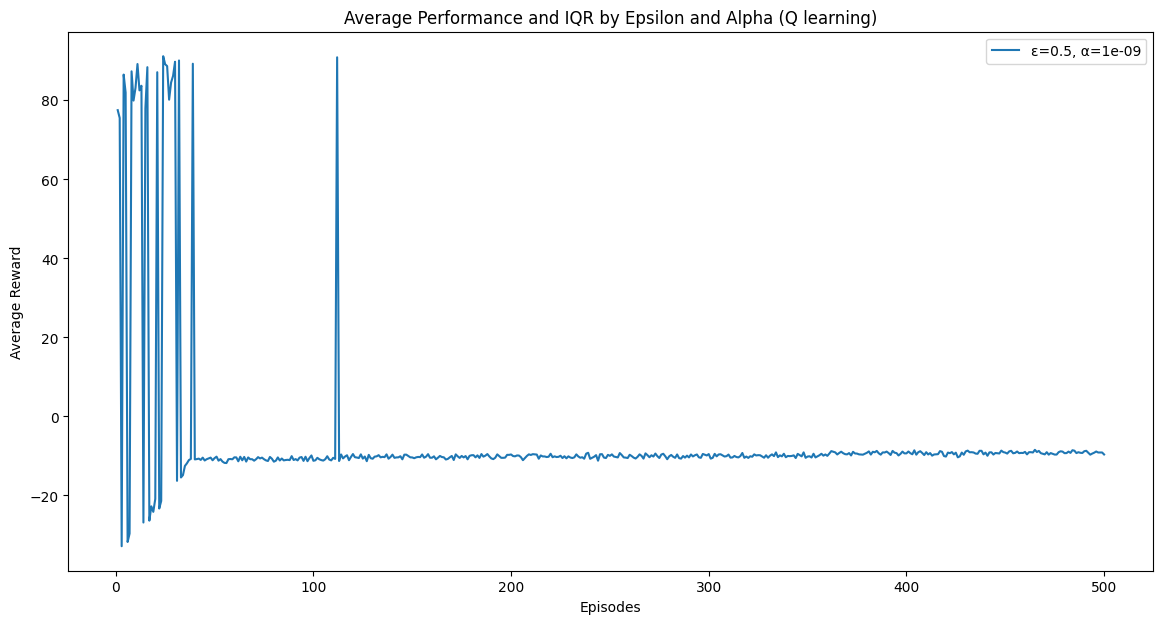

In [60]:
plot_rewards(rewards_data)


In [61]:
save_rewards_data(rewards_data, "MCC_DDQN_RBF_0.5_1run")

Rewards data saved to MCC_DDQN_RBF_0.5_1run


## Analysis

In [62]:
def combine_pickles_with_unique_alphas(pickle_files, output_file):
    combined_data = {}

    for pickle_file in pickle_files:
        with open(pickle_file, 'rb') as file:
            data = pickle.load(file)

            # Iterate over epsilon keys
            for epsilon, alphas in data.items():
                if epsilon not in combined_data:
                    combined_data[epsilon] = {}

                # Iterate over alpha keys
                for alpha, rewards in alphas.items():
                    if alpha not in combined_data[epsilon]:
                        # If this alpha is new for this epsilon, add it directly
                        combined_data[epsilon][alpha] = rewards
                    else:
                        # If this alpha already exists, extend the existing rewards list
                        combined_data[epsilon][alpha].extend(rewards)

    # Save combined data to a new pickle file
    with open(output_file, 'wb') as file:
        pickle.dump(combined_data, file)

    print(f"Combined pickle data saved to {output_file}")


# Example usage:
pickle_files = ['MCC_DDQN_RBF_0.4_1run',
                'MCC_DDQN_RBF_0.5_1run',
                'MCC_DDQN_RBF_0.1_1run'
                ]

combine_pickles_with_unique_alphas(pickle_files, 'MCC_DDQN_RBF_1run.pkl')

Combined pickle data saved to MCC_DDQN_RBF_1run.pkl


In [63]:
rewards_data = load_rewards_data('MCC_DDQN_RBF_1run.pkl')

Rewards data loaded from MCC_DDQN_RBF_1run.pkl


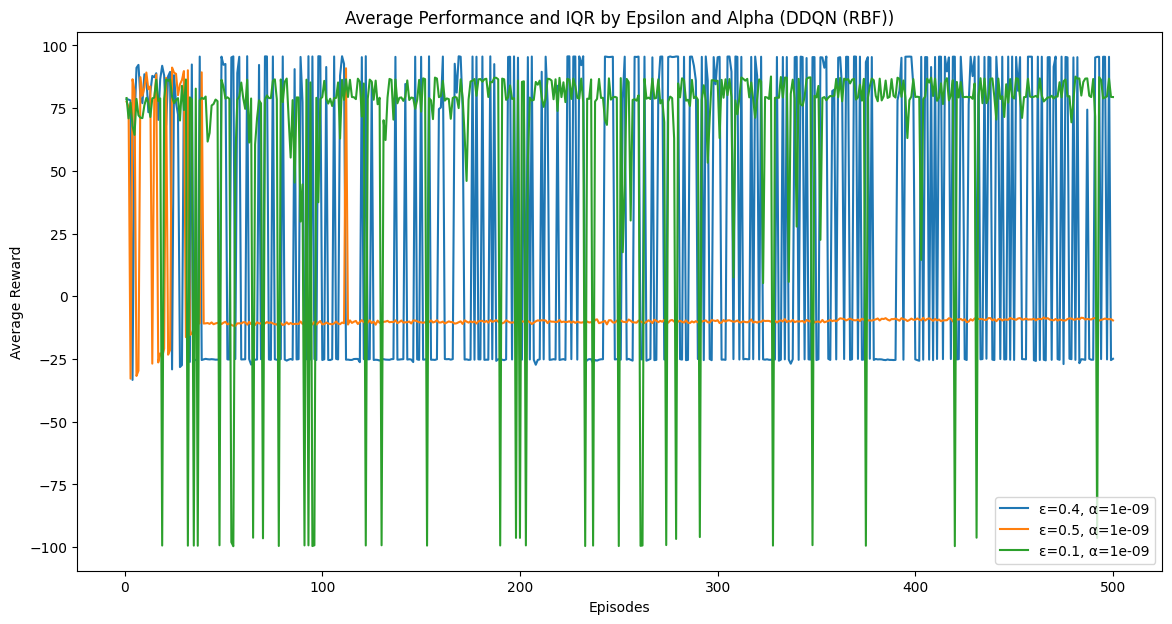

In [64]:
plot_rewards(rewards_data, "DDQN (RBF)")